In [1]:
import numpy as np
import random 
import torch
import torch.nn as nn
from matplotlib import pyplot as plt, ticker as mticker
import warnings
from datetime import datetime

warnings.simplefilter('ignore')

In [2]:
# Set seed for PyTorch
seed = 100
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Set seed for Python random module
random.seed(seed)

<Figure size 1500x400 with 0 Axes>

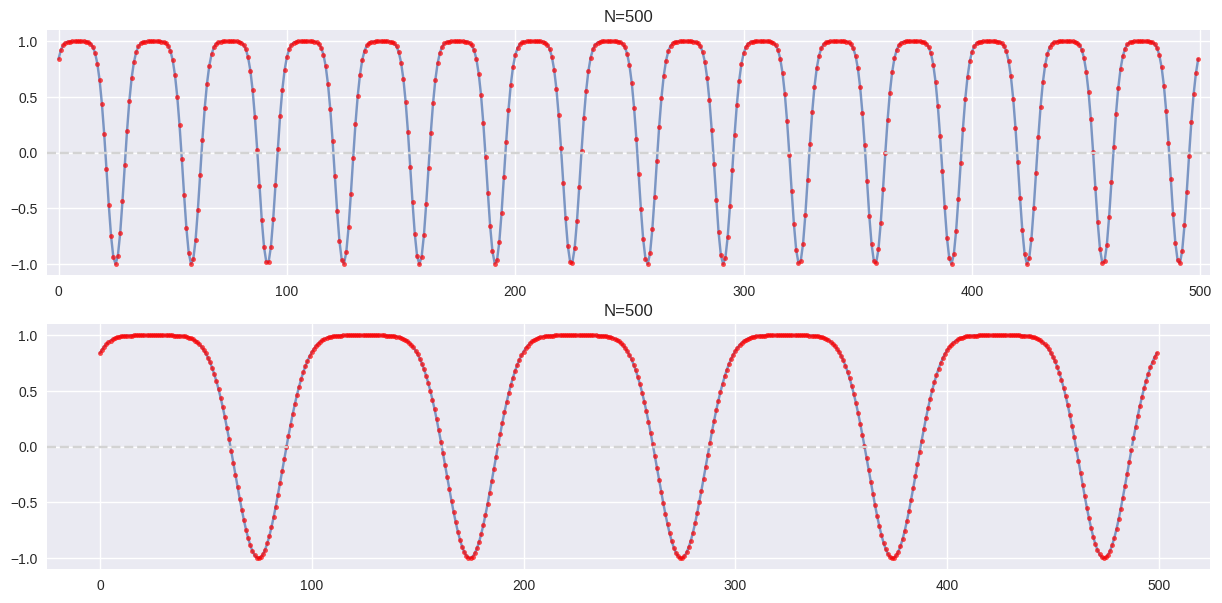

In [3]:
N = 500

def time(cap):
    return np.linspace(0,cap*np.pi,N)

data_30 = np.sin(time(30)+np.cos(time(30)))
data_10 = np.sin(time(10)+np.cos(time(10)))

plt.style.use('seaborn')
plt.figure(figsize=(15,4))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,7))
ax1.plot(data_30,'-', marker='.', markerfacecolor='red', alpha=0.7,label='data_30')
ax1.axhline(y=0, color='lightgrey', ls='--')
ax1.set_title(f'N={len(data_30)}')
ax2.plot(data_10,'-',marker='.', markerfacecolor='red', alpha=0.7, label='data_10')
ax2.axhline(y=0, ls='--', color='lightgrey')
ax2.set_title(f'N={len(data_10)}')
ax1.set_xlim([-5,N+4])
plt.show();

In [4]:
### build the dataset
series = data_30
T = 18
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (482, 18, 1) Y.shape (482, 1)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create RNN class

In [6]:
### Define simple RNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    # note: batch_first=True
    # applies the convention that our data will be of shape:
    # (num_samples, sequence_length, num_features)
    # rather than:
    # (sequence_length, num_samples, num_features)
    self.rnn = nn.RNN(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        nonlinearity = 'relu',
        batch_first = True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # get RNN unit output
    # out is of size (N, T, M)
    # 2nd return value is hidden states at each hidden layer
    # we don't need those now
    out, _ = self.rnn(X, h0)

    # we only want h(T) at the final time step
    # N x M -> N x K
    out = self.fc(out[:, -1, :])
    return out

In [7]:
# Instantiate the model
model = SimpleRNN(n_inputs=1, n_hidden=15, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [8]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [10]:
# move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [11]:
# Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=1000):

  # Stuff to store
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
      
    # Backward and optimize
    loss.backward()
    optimizer.step()

    # Save losses
    train_losses[it] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()
    dt = datetime.now() - t0

    if (it + 1) % 5 == 0:
      print(f"Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, " +
        f"Test Loss: {test_loss.item():.4f}, Duration: {dt}")

  
  return train_losses, test_losses

In [12]:
train_losses, test_losses = full_gd(model,
                                    criterion,
                                    optimizer,
                                    X_train,
                                    y_train,
                                    X_test,
                                    y_test)

Epoch 5/1000, Train Loss: 0.6013, Test Loss: 0.5937, Duration: 0:00:00.001324
Epoch 10/1000, Train Loss: 0.5706, Test Loss: 0.5632, Duration: 0:00:00.001355
Epoch 15/1000, Train Loss: 0.5395, Test Loss: 0.5317, Duration: 0:00:00.001479
Epoch 20/1000, Train Loss: 0.5067, Test Loss: 0.4986, Duration: 0:00:00.001630
Epoch 25/1000, Train Loss: 0.4745, Test Loss: 0.4666, Duration: 0:00:00.002392
Epoch 30/1000, Train Loss: 0.4420, Test Loss: 0.4334, Duration: 0:00:00.001645
Epoch 35/1000, Train Loss: 0.4072, Test Loss: 0.3981, Duration: 0:00:00.001363
Epoch 40/1000, Train Loss: 0.3709, Test Loss: 0.3613, Duration: 0:00:00.001337
Epoch 45/1000, Train Loss: 0.3331, Test Loss: 0.3233, Duration: 0:00:00.001354
Epoch 50/1000, Train Loss: 0.2960, Test Loss: 0.2864, Duration: 0:00:00.001365
Epoch 55/1000, Train Loss: 0.2581, Test Loss: 0.2485, Duration: 0:00:00.001952
Epoch 60/1000, Train Loss: 0.2205, Test Loss: 0.2108, Duration: 0:00:00.001548
Epoch 65/1000, Train Loss: 0.1827, Test Loss: 0.1731,

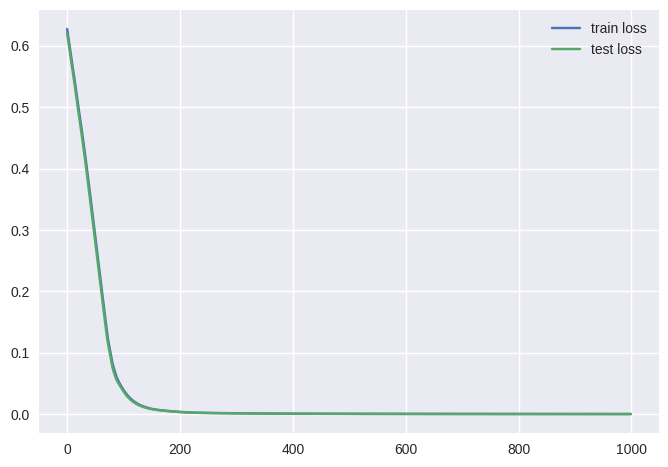

In [13]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [14]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
# while len(validation_predictions) < 90:  # omd: extrapolate beyond the validation dataset
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)
    # [0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p[0,0].item())

    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

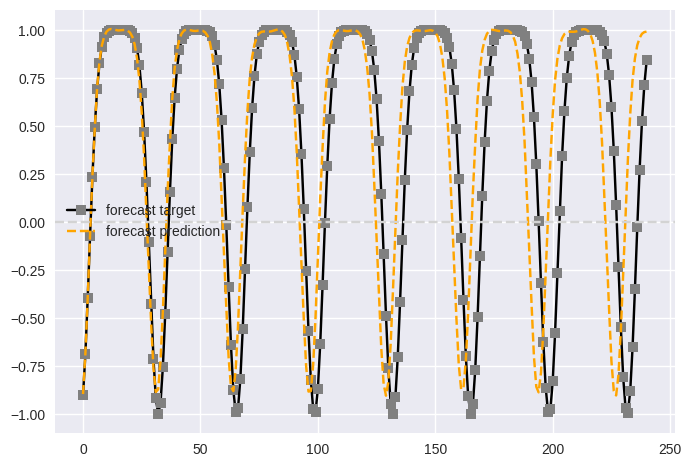

In [15]:
plt.plot(validation_target, 'ks-', markerfacecolor='grey', label='forecast target')
plt.plot(validation_predictions, label='forecast prediction', ls='--', color='orange')
plt.axhline(y=0, ls='--', color='lightgrey')
plt.legend();

In [16]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self, x):
    
    # run through the RNN layer
    y,hidden = self.rnn(x) # no explicit hidden state initialization
    
    # and the output (linear) layer
    y = self.out(y)
    
    return y,hidden